# Stable Diffusion with Neuronx: Text to image

`🤗 Optimum` extends `🤗 Diffusers` to support inference on the second generation of Neuron devices(powering Trainium and Inferentia 2). It aims at inheriting the ease of Diffusers on Neuron.

To get started, make sure you have [configured your inf2 / trn1 instance](https://huggingface.co/docs/optimum-neuron/installation), and installed optimum:

In [1]:
!pip install "optimum[neuronx, diffusers]" matplotlib

## Compilation

To deploy models, you will need to compile them to TorchScript optimized for AWS Neuron. In the case of Stable Diffusion, there are four components which need to be exported to the `.neuron` format to boost the performance:

* Text encoder
* U-Net
* VAE encoder
* VAE decoder

You can either compile and export a Stable Diffusion Checkpoint via CLI or `NeuronStableDiffusionPipeline` class. 
In this tutorial, we will export [`stabilityai/stable-diffusion-2-1`](https://huggingface.co/stabilityai/stable-diffusion-2-1) with the API.

In [2]:
from optimum.neuron import NeuronStableDiffusionPipeline

model_id = "stabilityai/stable-diffusion-2-1"
num_image_per_prompt = 1
input_shapes = {"batch_size": 1, "height": 768, "width": 768, "num_image_per_prompt": num_image_per_prompt}
compiler_args = {"auto_cast": "matmul", "auto_cast_type": "bf16"}

In [3]:
# Compile and save
stable_diffusion = NeuronStableDiffusionPipeline.from_pretrained(
    model_id, export=True, device_ids=[0, 1], **compiler_args, **input_shapes
)
# Load already exported artifacts
# stable_diffusion = NeuronStableDiffusionPipeline.from_pretrained("sd_neuron_768/", device_ids=[0, 1])

save_directory = "sd_neuron_768/"
stable_diffusion.save_pretrained(save_directory)

In [4]:
# Push to hub
stable_diffusion.push_to_hub(save_directory, repository_id="Jingya/stable-diffusion-2-1-neuronx", use_auth_token=True)

Feel free to use the following command as well:

```bash
optimum-cli export neuron --model stabilityai/stable-diffusion-2-1-base \
  --task stable-diffusion \
  --batch_size 1 \
  --height 768 `# height in pixels of generated image, eg. 512, 768` \
  --width 768 `# width in pixels of generated image, eg. 512, 768` \
  --num_images_per_prompt 1 `# number of images to generate per prompt, defaults to 1` \
  --auto_cast matmul `# cast only matrix multiplication operations` \
  --auto_cast_type bf16 `# cast operations from FP32 to BF16` \
  sd_neuron_768/
```

We Recommend `inf2.8xlarge` or larger for compilation. You will also be able to compile the models with a CPU-only instance *(needs ~35GB memory)* using the CLI with `--disable-validation`, which disables the validation of inference on neuron devices.

In the following section, we will run the pre-compiled model on Neuron devices, to reduce expenses, you can run inference with `inf2.xlarge` instance.

## Text-to-image Inference
With pre-compiled Stable Diffusion models, now generate an image with a prompt on Neuron:

In [5]:
from diffusers import DPMSolverMultistepScheduler

stable_diffusion = NeuronStableDiffusionPipeline.from_pretrained("Jingya/stable-diffusion-2-1-neuronx")
stable_diffusion.scheduler = DPMSolverMultistepScheduler.from_config(stable_diffusion.scheduler.config)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

In [6]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import time
import copy
import numpy as np 

  0%|          | 0/50 [00:00<?, ?it/s]

[Inference Time] 6.09 seconds.


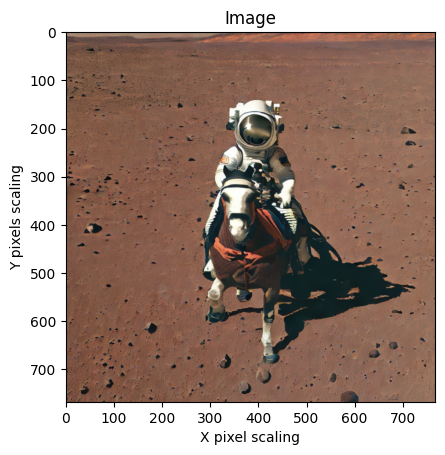

  0%|          | 0/50 [00:00<?, ?it/s]

[Inference Time] 6.05 seconds.


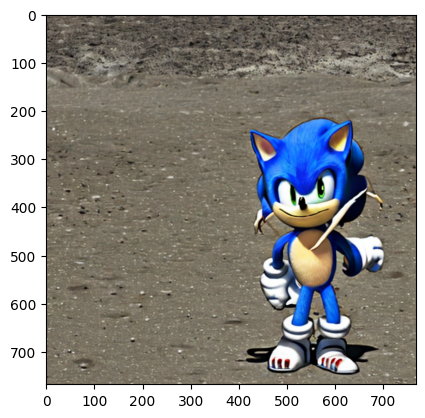

  0%|          | 0/50 [00:00<?, ?it/s]

[Inference Time] 6.07 seconds.


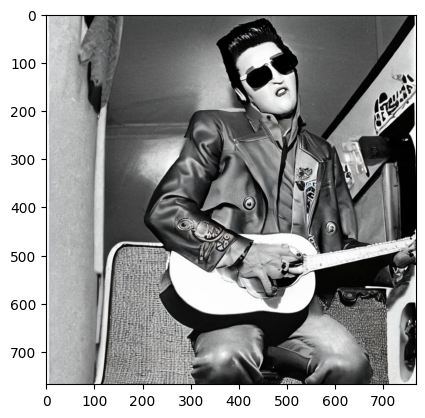

  0%|          | 0/50 [00:00<?, ?it/s]

[Inference Time] 6.05 seconds.


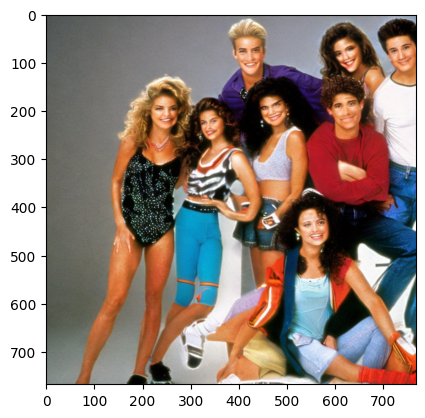

  0%|          | 0/50 [00:00<?, ?it/s]

[Inference Time] 6.07 seconds.


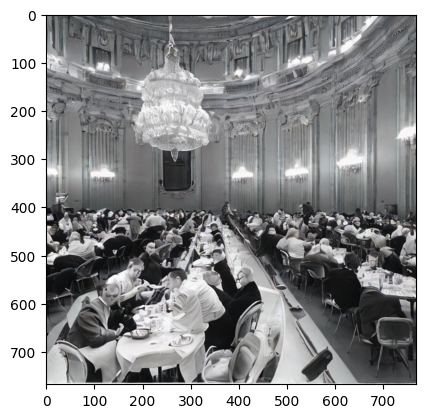

  0%|          | 0/50 [00:00<?, ?it/s]

[Inference Time] 6.05 seconds.


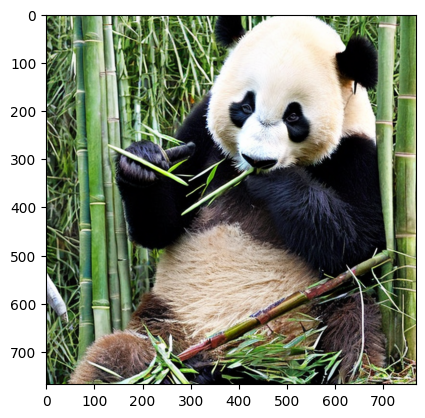

  0%|          | 0/50 [00:00<?, ?it/s]

[Inference Time] 6.06 seconds.


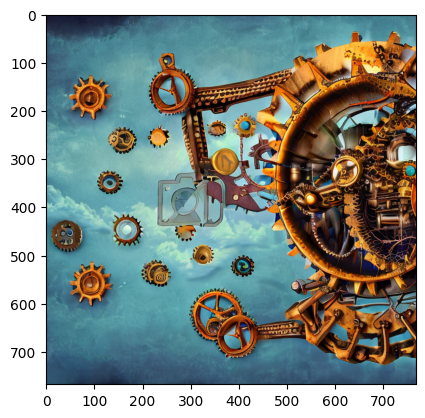

  0%|          | 0/50 [00:00<?, ?it/s]

[Inference Time] 6.05 seconds.


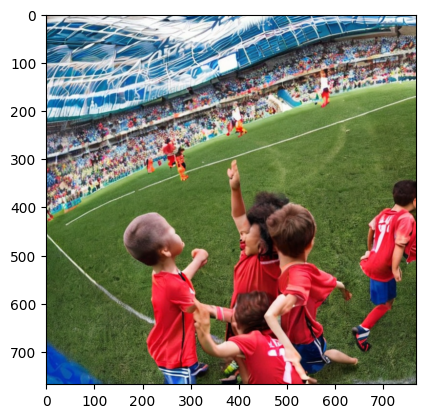

In [7]:
# Run pipeline
prompt = [
    "a photo of an astronaut riding a horse on mars",
    "sonic on the moon",
    "elvis playing guitar while eating a hotdog",
    "saved by the bell",
    "engineers eating lunch at the opera",
    "panda eating bamboo on a plane",
    "A digital illustration of a steampunk flying machine in the sky with cogs and mechanisms, 4k, detailed, trending in artstation, fantasy vivid colors",
    "kids playing soccer at the FIFA World Cup"
]


plt.title("Image")
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")

total_time = 0
for x in prompt:
    start_time = time.time()
    image = stable_diffusion(x).images[0]
    inf_time = time.time() - start_time
    print(f"[Inference Time] {np.round(inf_time, 2)} seconds.")
    image.save("image.png")
    image = mpimg.imread("image.png")
    #clear_output(wait=True)
    plt.imshow(image)
    plt.show()